In [1]:
import os
import cv2
from calibration_data import CameraCalibration
from video_processing import VideoProcessor, DetectionProcessor
from object_detection import YOLODetector

/Users/swayam/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/swayam/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_DIR = '../150821_dance3/'

In [3]:
def visualize_mesh(vertices, title="Mesh Visualization"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2])
    plt.title(title)
    plt.show()

In [4]:
calib_file = '../150821_dance3/calibration_150821_dance3.json'

video_dir = os.path.join(DATASET_DIR, 'hdVideos')

yolo_model_path = 'yolov8n.pt'

calib = CameraCalibration(calib_file)
video_processor = VideoProcessor(video_dir)
yolo_detector = YOLODetector(yolo_model_path)

detection_processor = DetectionProcessor(video_processor, yolo_detector)

In [ ]:
# detections_per_frame = detection_processor.process_all_frames()

In [5]:
import json
with open(calib_file, 'r') as f:
    calib_data = json.load(f)

In [6]:
import numpy as np
import numpy as np
import json
from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt

class FrustumProjection:
    def __init__(self, K, R, t):
        """
        Initializes the FrustumProjection class with camera intrinsic and extrinsic parameters.
        K: Intrinsic matrix (3x3)
        R: Rotation matrix (3x3)
        t: Translation vector (3x1)
        """
        self.K = np.array(K)  # (3, 3)
        self.R = np.array(R)  # (3, 3)
        self.t = np.array(t)  # (3, 1)
        self.inv_K = np.linalg.inv(self.K) 

    def bbox_to_frustum(self, bbox, near=0.1, far=10.0):
        """
        Projects the 2D bounding box into a 3D frustum by starting rays from each bbox corner.
        bbox: Bounding box in format [x1, y1, x2, y2]
        near: Near plane distance
        far: Far plane distance
        Returns the vertices of the frustum in world coordinates.

        NOTE: 
        1. Keep far value quite high to avoid clipping of the frustum.
        2. Keep near value low
        3. 
        """
        x1, y1, x2, y2 = bbox  

        corners = np.array([
            [x1, y1, 1], [x2, y1, 1],
            [x2, y2, 1], [x1, y2, 1]
        ])  # (4, 3)

        rays = np.dot(self.inv_K, corners.T).T  # (4, 3) # ray_dir_cam: image plane to camera coordinates

        frustum_vertices_near = self.extend_rays(rays, near)  # (4, 3) # ray_dir_cam * near
        frustum_vertices_far = self.extend_rays(rays, far)  # (4, 3) # ray_dir_cam * far

        frustum_vertices = np.vstack((frustum_vertices_near, frustum_vertices_far))  # (8, 3)

        return frustum_vertices

    def extend_rays(self, rays, depth):
        """
        Extends the rays from the camera center into the 3D world.
        rays: Rays in camera coordinates (4, 3)
        depth: Depth value (scalar)
        Returns the extended 3D points in world coordinates.
        """
        extended_rays = rays * depth  # (4, 3) # ray_dir_cam * depth

        world_points = np.dot(self.R, extended_rays.T).T + self.t.T  # (4, 3) # ray_dir_world: camera to world coordinates 

        return world_points

class Mesh:
    def __init__(self):
        self.meshes = []
        self.vertices = []
        self.faces = []

    def add_frustum(self, frustum_vertices):
        """
        Adds a frustum's vertices to the mesh.
        frustum_vertices: Vertices of the frustum (8, 3)
        """
        self.meshes.append(frustum_vertices)
        self.vertices.extend(frustum_vertices)
        self.faces.extend(self.compute_frustum_faces(frustum_vertices))

    def intersect_meshes(self):
        """
        Computes the intersection of all meshes added so far.
        Returns the intersection points if more than one mesh exists.
        """
        if len(self.meshes) < 2:
            return None

        intersection = self.meshes[0]  # Start with the first mesh
        for mesh in self.meshes[1:]:
            combined_points = np.vstack((intersection, mesh))  # Combine points (N, 3)
            hull_combined = ConvexHull(combined_points)  # Compute convex hull
            intersection = hull_combined.points[hull_combined.vertices]  # (M, 3)

        return intersection

    def compute_frustum_faces(self, frustum_vertices):
        """
        Constructs the 12 triangles forming the faces of the frustum.
        frustum_vertices: Vertices of the frustum (8, 3)
        Returns a list of triangles representing the frustum faces.
        """
        faces = [
            [0, 1, 2], [0, 2, 3],  # Near plane
            [4, 5, 6], [4, 6, 7],  # Far plane
            [0, 1, 5], [0, 5, 4],  # Side 1
            [1, 2, 6], [1, 6, 5],  # Side 2
            [2, 3, 7], [2, 7, 6],  # Side 3
            [3, 0, 4], [3, 4, 7]   # Side 4
        ]
        return faces

    def visualize_mesh(self, vertices, faces, title="Mesh Visualization"):
        """
        Visualizes the mesh vertices in a 3D plot.
        vertices: Vertices of the mesh (N, 3)
        faces: Faces of the mesh (list of triangles)
        title: Title of the plot
        """
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2])
        for face in faces:
            triangle = np.array([vertices[face[0]], vertices[face[1]], vertices[face[2]], vertices[face[0]]])
            ax.plot(triangle[:, 0], triangle[:, 1], triangle[:, 2], color="b")
        plt.title(title)
        plt.show()

In [7]:
def save_mesh_to_file(vertices, faces, filename):
    with open(filename, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {len(vertices)}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write(f"element face {len(faces)}\n")
        f.write("property list uchar int vertex_index\n")
        f.write("end_header\n")

        for vertex in vertices:
            f.write(f"{vertex[0]} {vertex[1]} {vertex[2]}\n")

        for face in faces:
            f.write(f"3 {face[0]} {face[1]} {face[2]}\n")

In [ ]:
# iterate over all frames and call detection_processor.process_current_frame_from_all_cameras to get detections



All meshes created
Intersection created


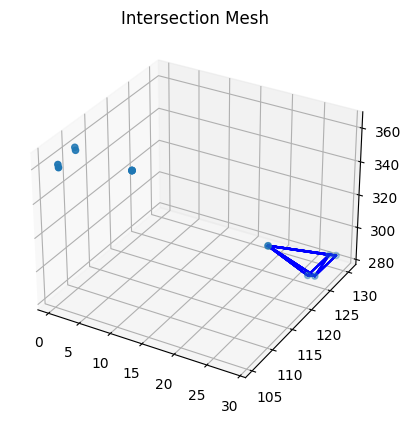

In [ ]:
cnt = 0

for frame_number, detections_list in detections_per_frame.items():
    # cnt += 1
    # if cnt <= 500:
    #     continue

    mesh = Mesh()
    for detection in detections_list:
        camera_name = detection['camera_name']
        detections = detection['detections']
        
        if len(detections) == 0:
            continue
            
        camera_params = next((c for c in calib_data['cameras'] if c['name'] == camera_name)
                              , None)

        if camera_params:
            frustum_projection = FrustumProjection(
                camera_params['K'],
                camera_params['R'],
                camera_params['t']
            )
            for det in detections:
                if det['class_id'] != 0:
                    continue
                
                bbox = det['bbox']
                frustum_vertices = frustum_projection.bbox_to_frustum(bbox)
                mesh.add_frustum(frustum_vertices)
        else:
            print(f"Alert: Camera {camera_name} not found in calibration data")

    print("All meshes created")

    intersection = mesh.intersect_meshes()

    print("Intersection created")
    
    if intersection is not None:
        mesh.visualize_mesh(np.array(mesh.vertices), mesh.faces, title="Intersection Mesh")
        save_mesh_to_file(intersection, mesh.faces, f"intersection_mesh_{frame_number}.ply")
    else:
        print("No intersection found sadly")

    break

video_processor.release()

In [ ]:
print(f"Length of mesh faces: {len(mesh.faces)}")
print(f"Length of intersection: {len(intersection)}")

Length of mesh faces: 24
Length of intersection: 13
